In [26]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import pyvinecopulib as pv
import statsmodels.api as sm
import statsmodels.formula.api as smf
from arch import arch_model
from statsmodels.distributions.copula.api import GaussianCopula, StudentTCopula

In [8]:
def download_data(tickers, start, end):
    data = yf.download(tickers=tickers, start = start, end = end)["Adj Close"]
    data = pd.DataFrame(
        np.diff(np.log(data[1:]), axis=0) * 100, columns=data.columns
    )
    data = data.dropna(axis=0)
    return data

In [9]:
data = download_data(tickers=["AAPL", "GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"], start = "2010-01-01", end = "2018-12-31")

[*********************100%***********************]  6 of 6 completed


In [48]:

def predict_next_period(data, VaR_level):
    garch_models = {}
    for column in data.columns:
        garch_models[column] = dict()
        am = arch_model(data[column], vol="Garch", p=1, o=0, q=1, dist="t", mean="constant").fit(disp='off')
        z = am.resid/am.conditional_volatility 
        u = am.model.distribution.cdf(z, parameters=am.params['nu'])
        garch_models[column]['arch_model'] = am
        garch_models[column]['z'] = z
        garch_models[column]['u'] = u

    u_data = pd.DataFrame()
    for ticker in data.columns:
        u_series = pd.Series(garch_models[ticker]['u'], name=ticker)
        u_data = pd.concat([u_data, u_series], axis=1)

    copula = StudentTCopula(k_dim=data.shape[1], df=3)
    copula.fit_corr_param(u_data)
    u_sim = pd.DataFrame(copula.rvs(nobs=1000), columns=data.columns)

    for ticker in garch_models.keys():
        z_sim = garch_models[ticker]['arch_model'].model.distribution.ppf(u_sim[ticker], parameters=am.params['nu'])
        garch_models[ticker]['z_sim'] = z_sim
        params = garch_models[ticker]['arch_model'].params
        sigma_next_period = np.sqrt(params['omega'] + params['alpha[1]'] * np.square(data[ticker].iloc[-1]) + params['beta[1]'] * np.square(garch_models[ticker]['arch_model']._volatility[-1]))
        next_period_returns = pd.Series(params['mu'] + sigma_next_period * garch_models[ticker]['z_sim'], name=ticker).sort_values()
        garch_models[ticker]['sigma_next_period'] = sigma_next_period
        garch_models[ticker]['next_period_returns'] = next_period_returns

    VaR = np.mean([v['next_period_returns'].quantile(VaR_level) for v in garch_models.values()])
    
    return VaR

In [49]:
result = pd.DataFrame(columns=['Portfolio', 'VaR'])

In [50]:
for i in range(data.shape[0]-1500-1):
    start = i
    end = start + 1500
    temp_data = data.iloc[start:end]
    print("start: ", start)
    print("end: ", end)
    res = predict_next_period(data=temp_data, VaR_level=0.01)
    print(res)
    result.loc[end+1, 'VaR'] = res
    result.loc[end+1, 'Portfolio'] = np.mean(data.iloc[end+1,:])

start:  0
end:  1500
-5.832446821441085
start:  1
end:  1501
-6.048381875440168
start:  2
end:  1502
-6.0471250057188
start:  3
end:  1503
-5.98604879569974
start:  4
end:  1504
-5.600236610472692
start:  5
end:  1505
-5.413677869659203
start:  6
end:  1506
-5.307787585814597
start:  7
end:  1507
-5.270579839655356
start:  8
end:  1508
-5.098690824369105
start:  9
end:  1509
-5.452452732153616
start:  10
end:  1510
-4.873272204107039
start:  11
end:  1511
-5.141431802806895
start:  12
end:  1512
-4.921597108652514
start:  13
end:  1513
-5.164690611808592
start:  14
end:  1514
-5.160902727970098
start:  15
end:  1515
-4.942896756917768
start:  16
end:  1516
-5.066059952679651
start:  17
end:  1517
-4.988056829415836
start:  18
end:  1518
-4.523615320251007
start:  19
end:  1519
-4.750517813527122
start:  20
end:  1520
-4.644174827918072
start:  21
end:  1521
-4.937791889798547
start:  22
end:  1522
-4.910465866654511
start:  23
end:  1523
-4.821518676246893
start:  24
end:  1524
-4.6103

<Axes: >

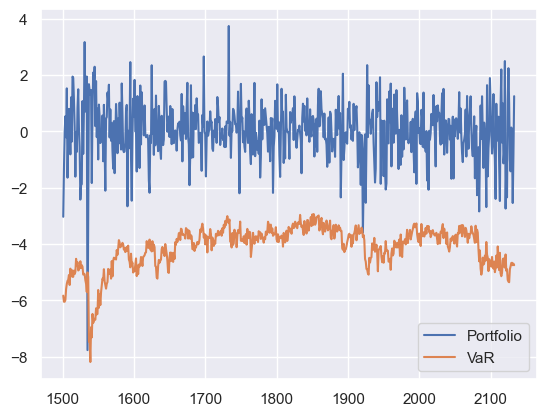

In [51]:
result.plot()

In [52]:
result.shape

(633, 2)

In [53]:
result[result['VaR']>result['Portfolio']]

,Portfolio,VaR
1535,-7.766053,-5.006776


<Axes: xlabel='Portfolio', ylabel='Density'>

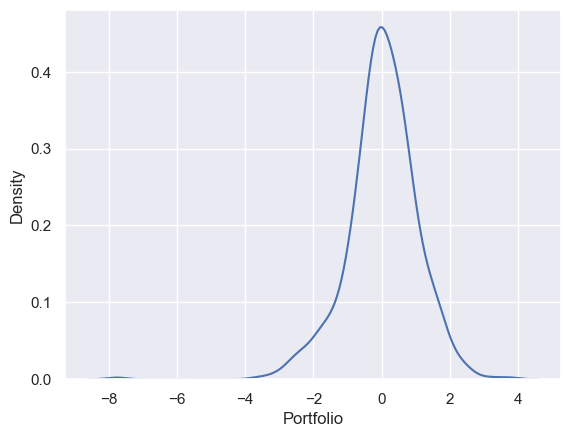

In [54]:
sns.kdeplot(result['Portfolio'])

$x_t = \mu + \sigma_t \epsilon_t\\
\sigma_t² = a_0 + a_1 x_{t-1}² + b_1 \sigma_{t-1}²$

epsilon = copula werte